
# Project Definition
## Project Overview: Building a Multi-Label Image Classification Algorithm for Formula 1 cars
In this notebook, we aim to create an algorithm capable of classifying all Formula 1 cars in an image into their respective teams/manufacturers. This could be the first step in building a specialized image search engine.

We use transfer learning on a pre-trained CNN and modify the last layers to adapt to our problem. Additionally, we tackle the challenge of identifying more than one class per image. This is achieved using a pre-trained Cascade Classifier for object detection on the image. Each detected object provides a section of the image to be used in our single-label classifier.

With this approach, we should be able to detect each F1 car in an image one by one. The single-label classification results can be evaluated and, if they meet certain criteria, aggregated to give the multi-label result.

## Problem Statement
In a Formula 1 season, multiple manufacturers design and build unique cars and compete, usually with two drivers per team. When you perform an image search for "Formula 1 racing," most resulting images contain more than one car, often from different manufacturers. Conventional methods for image classification return a confidence metric (probability) for each class. Typically, the class with the highest metric is returned as the classification result.

For images of Formula 1 racing, this approach will only be suitable for classifying the most prominent car in the image. It does not convey information about all depicted cars and is likely not the best approach. In this project, we explore a slightly different approach.

The unique challenge is the requirement to ascribe multiple classes to an image simultaneously. One idea is to use object detection to create multiple frames of the image. An image classifier can be used on each frame, producing a confidence metric for classifying a certain manufacturer. If the confidence is high enough, the corresponding class (manufacturer) is added to the result.

## Metrics
We need to define different metrics for our single-label classifier and our final multi-label result. The most important for both is **accuracy** , as our main focus is to optimize the proportion of correct classification results. Precision and Recall will also be important for both. To consider them, we will use the **F1-score** as an additional metric.

For Multi-label classification we need to consider additional aspects.

#### Precision
Precision in multi-label classification measures the proportion of predicted labels that are actually relevant

**Micro Precision**: This aggregates the contributions of all classes to compute the average metric. It's calculated by summing up the True Positives (TP) and False Positives (FP) across all labels and then computing the precision as:

>Micro Precision = (sum of True Positives) / (sum of True Positives + sum of False Positives)

**Macro Precision**: This calculates precision for each label independently and then takes the average, treating all labels equally regardless of their frequency:

>Macro Precision = (1 / L) * sum (TP_l / (TP_l + FP_l))

where `L` is the total number of labels.

#### Recall
Recall in multi-label classification measures the proportion of relevant labels that are correctly predicted.

**Micro Recall**: This is calculated similarly to micro precision but focuses on the recall aspect:

>Micro Recall = (sum of True Positives) / (sum of True Positives + sum of False Negatives)

**Macro Recall**: This calculates recall for each label independently and then takes the average:

>Macro Recall = (1 / L) * sum (TPl / (TPl + FN_l))

where `L` is the total number of labels.

These metrics can be skewed by infrequent labels. This however should not be a problem in our application, since the number of cars per team is equally distributed and so is our data.

**Partial Accuracy**: Describes the ratio of classifications with partial correctness, meaning at least one car in the image is classified correctly.



# Analysis
## Data Exploration
We need two different datasets for our problem.

#### Single Car Images
The first set contains images of **single Formula 1 cars** from the 2019 season. It is needed to train the single-label classifier. As mentioned in the problem statement these type of images are comparatively rare in Formula 1. The images are stored in 10 directorys, representing the 10 different classes:

    - Ferrari
    - Merceds
    - Red Bull
    - McLaren
    - Renault
    - BWT
    - Torro Rosso
    - Haas
    - Alfa Romeo
    - Williams

We split these images into 3 datasets:

The training images also need to contain cars from **multiple perspectives** since we expect this as well from images of racing situations. For these reason we use a specifically selcected dataset. It contains rendered images of the cars from each manufacturer of the 2019 Formula 1 season. This enables the possibility of fullfilling both criteria easily.


#### Images of Racing Situations
The second dataset contains images of the type our final algorithm has to handle. They contain multiple cars often from diffent teams.



In [187]:
# Make all necessary imports.
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from PIL import Image
import cv2
import tensorflow_hub as hub
import tf_keras
import tensorflow as tf
from tf_keras.preprocessing.image import ImageDataGenerator
from tf_keras.optimizers import Adam
from scipy.ndimage import rotate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Loading Training Data for Single-Label Classifier
We load the training data into keras datasets. All training images have a size of (1080x1980). We resize the images to a size of 540x990. We split the data into 3 Sets:

- ds_train - training data, 70% of the data
- ds_val - validation data, 20% of the data
- ds_test - testing data, 10% of the data

Each set contains data in batches the size of 32 Images.

In [12]:
# path of current directory
current_dir = Path.cwd()

# path to data dir
data_dir_single = current_dir / 'data/single_car'
# data_dir = current_dir.parent / 'F1 Car Recognition.v10-v6'


if not data_dir_single.exists():
    raise FileNotFoundError(f'The directory {data_dir_single} does not exist.')

# defining split ratios
validation_split = 0.2
test_split = 0.1
seed = 123
image_size = (540, 990)
batch_size = 32
total_val_test_split = validation_split + test_split

# Create training and remainder datasets
ds_train = tf_keras.preprocessing.image_dataset_from_directory(
    data_dir_single,
    validation_split=total_val_test_split,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

# Create combined validation and test dataset
ds_val_test = tf_keras.preprocessing.image_dataset_from_directory(
    data_dir_single,
    validation_split=total_val_test_split,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size
)

# Further split the combined validation and test dataset
val_size = int((validation_split / total_val_test_split) * ds_val_test.cardinality().numpy())
test_size = ds_val_test.cardinality().numpy() - val_size

ds_val = ds_val_test.take(val_size)
ds_test = ds_val_test.skip(val_size)

# Show information about the loaded data
class_names = ds_train.class_names
print(f'Classes: {class_names}')
print(f'number of training batches: {ds_train.cardinality().numpy()}')
print(f'number of validation batches: {ds_val.cardinality().numpy()}')
print(f'number of testing batches: {ds_test.cardinality().numpy()}')

Found 9525 files belonging to 10 classes.
Using 6668 files for training.
Found 9525 files belonging to 10 classes.
Using 2857 files for validation.
Classes: ['alfa_romeo', 'bwt', 'ferrari', 'haas', 'mclaren', 'mercedes', 'redbull', 'renault', 'toro_rosso', 'williams']
number of training batches: 209
number of validation batches: 60
number of testing batches: 30


### Loading Testing Data for Final Model Evaluation
We load the evaluation data into a single keras datasets. Since we dont use this data for training, no split is needed.

In [119]:
# path to data dir
data_dir_multi = current_dir / 'data/multi_car'
# data_dir = current_dir.parent / 'F1 Car Recognition.v10-v6'


if not data_dir_multi.exists():
    raise FileNotFoundError(f'The directory {data_dir_multi} does not exist.')

# defining split ratios
seed = 123
image_size = (540, 990)

# Create training and remainder datasets
ds_multi = tf_keras.preprocessing.image_dataset_from_directory(
    data_dir_multi,
    seed=seed,
    image_size=image_size,
    batch_size=1
)

# Show information about the loaded data
class_names_multi = ds_multi.class_names
print(f'Classes: {class_names_multi}')

Found 30 files belonging to 20 classes.
Classes: ['alfaromeo_bwt', 'alfaromeo_mclaren', 'alfaromeo_tororosso', 'bwt_haas', 'bwt_mclaren', 'bwt_renault', 'ferrari_alfaromeo', 'ferrari_haas', 'ferrari_mclaren', 'ferrari_mercedes', 'ferrari_redbull', 'ferrari_tororosso', 'haad_redbull', 'haas_tororosso', 'mclaren_redbull', 'mclaren_renault', 'mclaren_tororosso', 'mercedes_ferrari_redbull', 'mercedes_mclaren', 'mercedes_redbull']


## Data Visualisation

As mentioned in the problem statement it is hard to find images of single formula 1 cars on the track. The training images also need to contain cars from multiple perspectives since we expect this as well from images of racing situations. For these reason we use a specifically selcected dataset. It contains rendered images of the cars from each manufacturer of the 2019 Formula 1 season. This enables the possibility of fullfilling both criteria easily.

<img src="images/Example_of_Training_Data.png" width=1000px>

We print single images of the dataframes using the label as a title to verify our loading process.

First an image containing single cars used for training our single-label classifier.

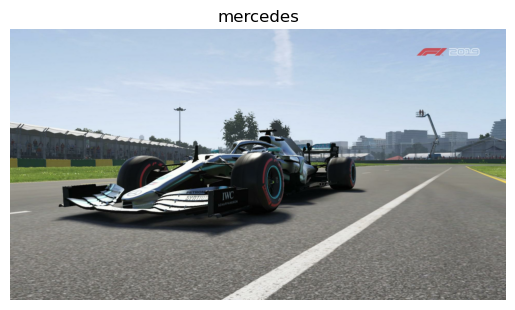

In [35]:
def plot_image_from_dataset(dataset, num_img=1):
    '''
    Function to plot random images of a dataset
    Args:
        dataset - Dataset to plot images from 
        num_img = 1 - int of number of images to plot
    Returns:
        y_pred: prediction of the model
    '''
    class_names = dataset.class_names
    # Take one batch from the dataset
    for images, labels in dataset.take(1):
        for i in range(num_img):  # Change '3' to the number of images you want to plot
            plt.figure()
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i])])
            plt.axis("off")
            plt.show()

# Plot a random image from the dataset
plot_image_from_dataset(ds_train)

And secondly an image containing multiple F1 cars we use for the evaluation of our final algorithm.

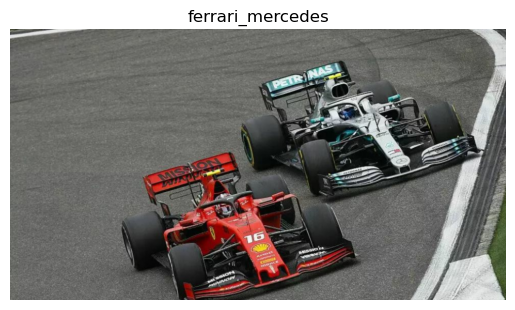

In [36]:
plot_image_from_dataset(ds_multi)

# Methology
## Data Preprocessing
To prepare the data for a Machine Learning Pipeline we first need to resize it for the input layer of MobileNetV3. This pre-trained model requires that the input images have color values in the range `[0,1]` and a size of `(224, 224)`. We will therefore have to normalize the pixel values of our images and resize them to the appropriate size. We can normalize our pixel values in the usual way by dividing the original pixel values by `255` and to resize our images we can use the `tf.image.resize()` function.

To enhance the generalisation during training we use feature augmentation. The following operations are performed:
* random_flip_left_right
* random_flip_up_down(image)
* random_brightness(image, max_delta=0.1)
* random_contrast(image, lower=0.9, upper=1.1)
* random_rotate(-30, 30)

This will augment our training data and should boost the performance of the classifier.

In [15]:
# TODO: Create a pipeline for each set.
num_training_examples = len(ds_train)

def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image /= 255

    return image, label

# Custom rotation function using NumPy
def random_rotate_np(image):
    # Rotate the image by a random angle between -30 and 30 degrees
    angle = np.random.uniform(-30, 30)
    rotated_image = rotate(image, angle, reshape=False)

    return rotated_image

# defining function for data augmentation
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.numpy_function(random_rotate_np, [image], tf.float32)

    return image, label

training_batches = ds_train.shuffle(num_training_examples//4).map(format_image).map(augment_image).prefetch(1)
validation_batches = ds_val.map(format_image).prefetch(1)
testing_batches = ds_test.map(format_image).prefetch(1)

## Implementation
###  Building a Model for Single-Label Classification
The Classifier should be capepable of determining the manufacturer of Formula 1 car in an image using multi-class and single-label classification. To do this we build a ML pipeline using transfer learning from [MobileNetV3](https://keras.io/api/applications/mobilenet/)

<img src="images/MobileNetV3.JPG" width=800px>

We need to:
* Load the MobileNet pre-trained network from TensorFlow Hub.
    
    [TensorFlow Hub](https://www.tensorflow.org/hub) is an online repository of pre-trained models. In addition to complete pre-trained models, TensorFlow Hub also contains models without the last classification layer. These models can be used to perform transfer learning by adding a classification layer that suits the number of classes in your particular dataset.

* Define a new, untrained feed-forward network as a classifier.

    In our case we need 10 output neurons for our final layer since we want to identify 10 different classes.

In [16]:
# path where the model is extracted
local_model_path = 'mobilenet-v3-tensorflow2-large-075-224-feature-vector-v1'

# Building our model.
# URL = "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5"
feature_extractor = hub.KerasLayer(local_model_path, input_shape=(224, 224, 3))

feature_extractor.trainable = False

model = tf_keras.Sequential([
        feature_extractor,
        #tf_keras.layers.Dropout(0.15),
        #tf_keras.layers.Dense(32, activation='relu'),
        tf_keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2731616   
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2744426 (10.47 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 2731616 (10.42 MB)
_________________________________________________________________


### Compiling the Model
We use an Adam optimizer with a learning rate of 0.0001. This proved to be the best setting. Our most important metric is accuracy, therefore we use it during training.

In [17]:
# Create an Adam optimizer with the specified learning rate
custom_optimizer = Adam(learning_rate=0.0001)

# compile the model
model.compile(optimizer=custom_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

###  Training the Classifier
We train the classifier on the training set using 100 Epochs.

In [18]:
EPOCHS = 100

history = model.fit(training_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

In [19]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
accuracy_train = history.history['accuracy']
accuracy_validation = history.history['val_accuracy']

loss_train = history.history['loss']
loss_validation = history.history['val_loss']

epochs_range=range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy_train, label='Training Accuracy')
plt.plot(epochs_range, accuracy_validation, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_train, label='Training Loss')
plt.plot(epochs_range, loss_validation, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<img src="images/BaseLine_History.png" width=1200px>

### Testing the Network on Single-Car Images

It's good practice to test trained networks on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images. 

In [20]:
# Print the loss and accuracy values achieved on the entire test set.
loss_test, accuracy_test = model.evaluate(testing_batches)

print(f'\nLoss on the Test Set: {loss_test:,.3f}')
print(f'Accuracy on the Test Set: {accuracy_test:.3%}')

30/30 [==============================] - 10s 137ms/step - loss: 2.4571 - accuracy: 0.0736

Loss on the Test Set: 2.457
Accuracy on the Test Set: 7.364%


The classifier performs well on images of single Formula 1 cars. 

### Saving the model
We save the model for usage in the future. This is done beacause the training process takes a long time and doesnt need to be repeated each time this Notebook is loaded.

In [21]:
# path to data dir
filepath = current_dir / 'saved_models/F1_2019_Image_Classifier_V1.h5'

# Saving the trained model as a Keras model.
model.save(filepath)

c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Loading the model

In [22]:
# path of current directory
current_dir = Path.cwd()

# path to model dir
filepath = current_dir / 'saved_models/F1_Image_Classifier_DO_0p1__LR_0p0001.h5'

# loading the model
reloaded_model = tf_keras.models.load_model(filepath, custom_objects={'KerasLayer':hub.KerasLayer})

# returning a summary of the model
reloaded_model.summary()

# defining class names
class_names = ['alfa_romeo', 'bwt', 'ferrari', 'haas', 'mclaren', 'mercedes', 'redbull', 'renault', 'toro_rosso', 'williams']

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  (None, 1280)              2731616   
                                                                 
 dropout_7 (Dropout)         (None, 1280)              0         
                                                                 
 dense_10 (Dense)            (None, 10)                12810     
                                                                 
Total params: 2744426 (10.47 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 2731616 (10.42 MB)
_________________________________________________________________


In [23]:
# Print the loss and accuracy values achieved on the entire test set.
loss_test, accuracy_test = reloaded_model.evaluate(testing_batches)

print(f'\nLoss on the Test Set: {loss_test:,.3f}')
print(f'Accuracy on the Test Set: {accuracy_test:.3%}')

30/30 [==============================] - 8s 130ms/step - loss: 1.1884 - accuracy: 0.8058

Loss on the Test Set: 1.188
Accuracy on the Test Set: 80.576%


### Testing the Model on Multi-Car Images
Now its time to see how predictions look on images with multiple cars.

In [24]:
# Create the process_image function to prepare images for prediction
def process_image(image):
    '''
    Function to process an image in preperation for prediction
    Args:
        image - image to be prepared
    Returns:
        image - image ready for prediction
    ''' 
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image /= 255
    image = image.numpy()

    return image

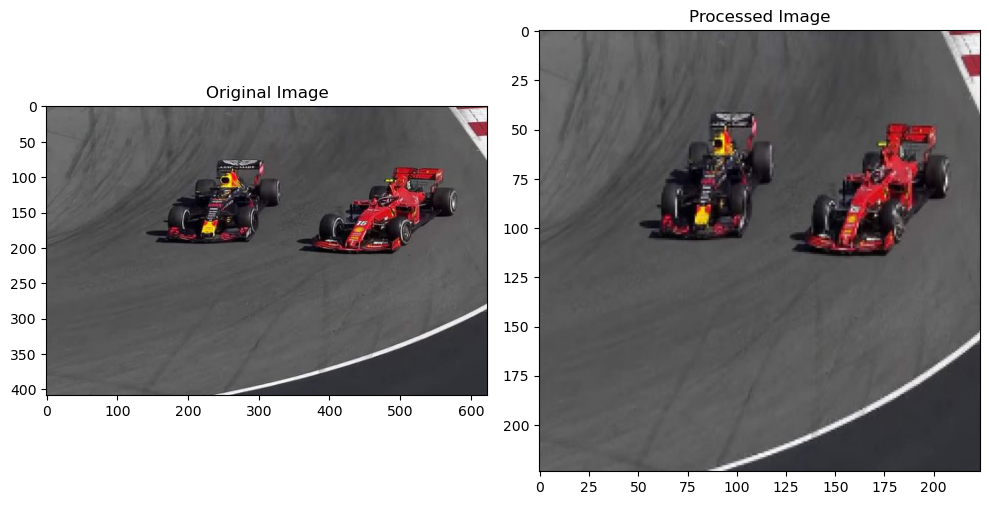

In [25]:
# plotting a multiclass image to test process_image
# path to image
img_dir = current_dir.parent / 'data/multi_car/ferrari_redbull'
image_path = os.path.join(img_dir, 'multi_1.jpg')

# loading image and transfroming it to np.array
img_multi = Image.open(image_path)
img_multi_arr = np.asarray(img_multi)

# processing image
processed_test_image = process_image(img_multi_arr)

# plotting image
fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(img_multi_arr)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

In [26]:
def predict(image, model, top_k=10):
    '''
    Function making single-label classification prediction
    Args:
        image - image to be classified
        model - model used for prediction
        top_k=10 - number of sorted prediction to be returned
    Returns:
        probs - list of probabilitys for predecitons
        classes - list of predicted classes
    '''    
    test_image = np.asarray(image)
    processed_image = np.expand_dims(process_image(test_image), axis=0)
    # print(processed_image.shape)
    prediction = model.predict(processed_image, verbose=0).squeeze();
    idx_prediction_sorted = np.argsort(prediction)[::-1]
    idx_top = idx_prediction_sorted[0:top_k]
    
    probs = prediction[idx_top]

    classes = []

    for i in range(top_k):
        classes.append(idx_top[i])
          
    return probs, classes

[0.17997041 0.17818406 0.1368069  0.1350561  0.12403065 0.05817721
 0.05815751 0.05810111 0.05742875 0.0140874 ]
[0, 3, 6, 1, 5, 8, 9, 2, 7, 4]
predicted manufacturer:  alfa_romeo with probability:  0.17997041
predicted manufacturer:  haas with probability:  0.17818406


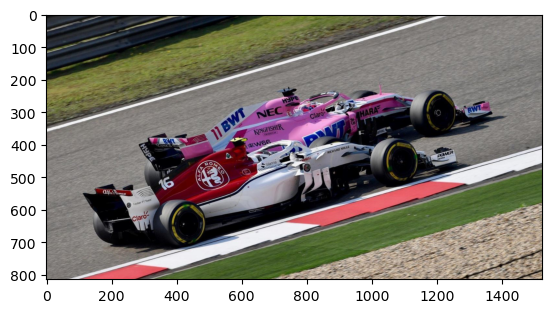

In [62]:
# using predict on a single car image
# path to image
img_dir = current_dir / 'data/multi_car/alfaromeo_bwt'
image_path = os.path.join(img_dir, 'multi_1.JPG')

# loading image
img = Image.open(image_path)

# making a prediction
probs, classes = predict(img, reloaded_model)

# printing results
print(probs)
print(classes)
print('predicted manufacturer: ', class_names[classes[0]], 'with probability: ', probs[0])
print('predicted manufacturer: ', class_names[classes[1]], 'with probability: ', probs[1])

# plotting the image
plt.imshow(img)
plt.show()

As expected our algorithm is not yet capable of performing the task. The correct classifications would be Alfa Romeo and BWT An image containing more than one car returns a classification result corresponding to only one of the labels with confidence. To tackle this problem we need a different approach.

### Implementing Object Detection
One possible solution to our problem is to detect prominent objects in the image. By doing this we can obtain multiple frames of a single image. These frames can than be processed by our single-label classifier to predict if and which Forumla 1 car is in the frame.

One common aproach for object detection in images are Cascade Classifiers.

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect cars in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded some of these detectors and stored them in the `saved_models/` directory.

In [172]:
def detect_frames(image, plot=False):
    '''
    Function using a Haar feature-based cascade classifier to detect cars
    Args:
        image - image to be investigated
        plot=False - bool if True, plots images of the frames
    Returns:
        frame_lst - list of images containing frames classified as cars
    '''    
    # convert image to np.array
    image_arr = image.numpy().astype("uint8")
    image_with_rectangles = image_arr.copy()
   
    # Convert the image to grayscale
    grey = cv2.cvtColor(image_arr, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to the grayscale image
    blur = cv2.GaussianBlur(grey, (5, 5), 0)
    
    # Apply dilation to the blurred image
    dilated = cv2.dilate(blur, np.ones((3, 3)))
    
    # Apply morphological closing to the dilated image
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
    closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)
    
    # Use CascadeClassifier for car detection
    car_cascade_src = 'saved_models/checkcas.xml'
    car_cascade = cv2.CascadeClassifier(car_cascade_src)
    cars = car_cascade.detectMultiScale(closing, 1.1, 1)
    
    # Draw rectangles around each detected car and count
    cnt = 0
    frames_lst = []

    for (x, y, w, h) in cars:
        cv2.rectangle(image_with_rectangles, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cnt += 1
        car_img = image_arr[y:y+h, x:x+w]
        frames_lst.append(car_img)

    if plot:
        # Print the total number of detected cars
        print(cnt, " frames found")

        plt.imshow(image_with_rectangles)
        plt.axis("off")
        plt.show()

    return frames_lst

### Testing the Object Detection
We used an Haar feature-based cascade classifiers pretrained for the purpose of detecting single cars from traffic images. It is provided here: [checkcas.xml](https://github.com/abhi-kumar/CAR-DETECTION/blob/master/checkcas.xml)
This seems to be the best choice for our application although it has some drawbacks.



31  frames found


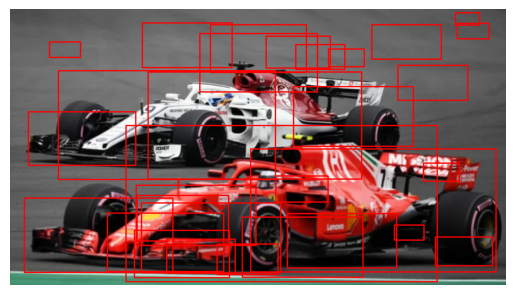

In [165]:
# define the path to a multi car images
img_dir = current_dir / 'data/multi_car/ferrari_alfaromeo'
image_path = os.path.join(img_dir, 'multi_1.jpg')

# load the image
tf_image = tf.io.read_file(image_path)

# convert the format
tf_image = tf.image.decode_jpeg(tf_image, channels=3)
tf_image = tf.image.convert_image_dtype(tf_image, tf.float32)
tf_image_uint8 = tf.image.convert_image_dtype(tf_image, dtype=tf.uint8)

# detect frames in the image the cascade classifier interprets as cars
frame_lst = detect_frames(tf_image_uint8, plot=True)

The cascade classifier has not been pre trained on Formula 1 cars specifically and therefore has some problems detecting them accurately. We see multiple frames, many of them not containing elements of the cars.

However in our approach we implement a second classification algorithm capable of not only identifying the most likely manufacturer of a car but also a confidence metric in the classification. If the object detecting missclassifies a frame which does not contain a Formula 1 car, the single-label classifier will have little confidence in its prediction and we can ignore it.

### Combining the Single-Label Classifier with the Object Detection Classifier
We create an algorithm that starts with object detection on an image. It passes all detected frames to the single-label classifier we trained to classify Formula 1 cars. If the single-label classifier has high confidence in the identificatíon of a certain car in the frame, i.e. one class probability is higher then a certain threshhold. The classification result is considered valid and added to the multi-label classification.

In [159]:
def is_monotone_by_saturation(image, threshold=30):
    '''
    Function to determine if an image has monotone saturation or not
    Args:
        image - image to be investigated
        threshold - saturation thrshold
    Returns:
        bool - True if saturation is monotone
    '''
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Get the saturation channel
    saturation = hsv_image[:, :, 1]

    # Compute average saturation
    mean_saturation = np.mean(saturation)

    return mean_saturation < threshold


def evaluate_frames(frame_lst, model, plot=False):
    '''
    Function to make predictions multiple frames of an image
    Args:
        frame_lst - list of images (frames)
    Returns:
        top_pred_lst - list of class and probability for frames with non monotone
                       saturation
    '''
    top_pred_lst = []#np.zeros((len(frame_lst), 2))

    cnt = 0

    # loop through all the frames and make predictions of them
    for frame in frame_lst:
        # preselect the frame for size and saturation 
        if frame.size > 25000 and\
            is_monotone_by_saturation(frame)==False:

            probs, classes = predict(frame, model)
            top_pred_lst.append([classes[0], probs[0], frame])

            cnt += 1
        else:
            continue
           
        # if is_monotone_by_saturation(frame)==False:
        #     # isolate the class and probability of the top prediction
        #     top_pred_lst.append([classes[0], probs[0], frame])
        # else:
        #     continue
    if plot:
        print('Number of frames suitable for single label classification: ', cnt)
            
    return top_pred_lst

 
def multi_label_prediction(image, model, threshold=0.95, plot=False):
    '''
    Function to make predictions of all classes contained in an image
    Args:
        image - image to be investigated
        model - single-label classification model
        thrshold - float determining the necessary prbability a frame needs to be
                         classified to be considered one of the returned classes
        plot - bool to activate debug mode
    Returns:
        classified_labels - list of unique class names identyfied
        unique_top_pred_lst - list unique classes identified by at least one frame
    '''
    frame_lst = detect_frames(image, plot)       

    # make predictions of all frames
    top_pred_lst = evaluate_frames(frame_lst, model, plot)

    # filter out predictions with a probability lower than a threshhold
    top_pred_lst_filtered = []
    
    top_pred_lst_filtered = [pred for pred in top_pred_lst if pred[1] > threshold]
    
    # Select the unique row of every class (column 0) with the highest probability (column 1)
    unique_top_pred_arr = {}

    for pred in top_pred_lst_filtered:
        class_label = int(pred[0])
        prob = pred[1]

        if class_label not in unique_top_pred_arr:
            unique_top_pred_arr[class_label] = pred
        else:
            if prob > unique_top_pred_arr[class_label][1]:
                unique_top_pred_arr[class_label] = pred

    # Convert dictionary to a list of numpy arrays
    unique_top_pred_list = list(unique_top_pred_arr.values())

    classified_labels = []

    for class_idx in range(len(unique_top_pred_list)):
        class_name = class_names[int(unique_top_pred_list[class_idx][0])]
        classified_labels.append(class_name)

        # plt.imshow(frame_lst[int(unique_top_pred_list[class_idx][0])])
        # plt.show()

    return classified_labels, unique_top_pred_list 

### Sanity Check for the Combined Classifier
Before we evaluate our multi-label image classifier on images from the multi car test set it makes sense to do a sanity check. To do this we use the "debug mode" (plot=True) of the involved functions and show plots about the images and frames they process. This should help us to understand the steps of the algorithm in detail. For the sanity check we load single image and check each step of the algorithm. This gives us some insight about how the algorithm works.

23  frames found


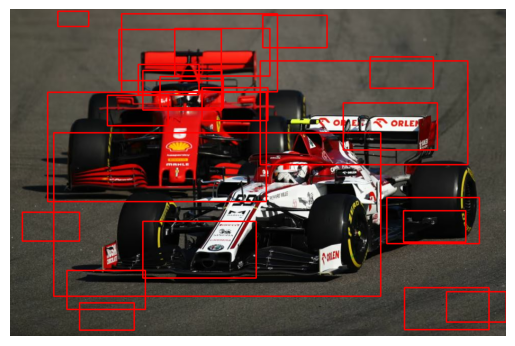

23  frames found


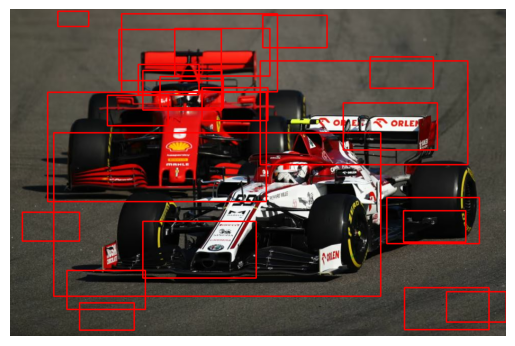

Number of frames suitable for single label classification:  13
['alfa_romeo', 'ferrari', 'renault']
Frame Classification result:  alfa_romeo
0.3435098


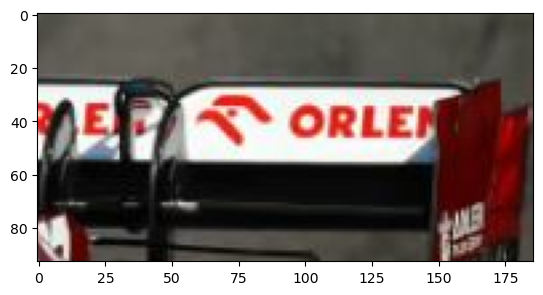

Frame Classification result:  ferrari
0.764991


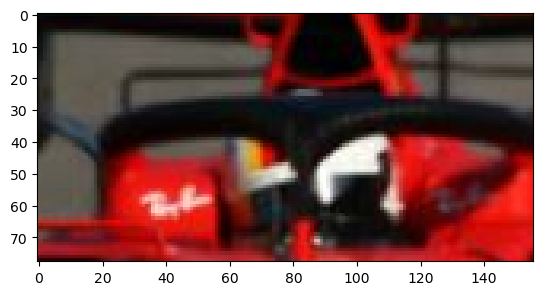

Frame Classification result:  renault
0.3868603


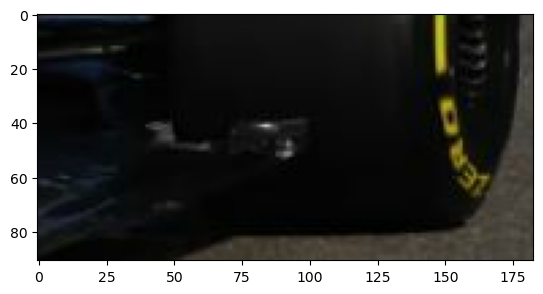

In [162]:
# define the path to a multi car images
img_dir = current_dir / 'data/multi_car/ferrari_alfaromeo'
image_path = os.path.join(img_dir, 'multi_2.jpg')

# load the image
tf_image = tf.io.read_file(image_path)

# convert the format
tf_image = tf.image.decode_jpeg(tf_image, channels=3)
tf_image = tf.image.convert_image_dtype(tf_image, tf.float32)
tf_image_uint8 = tf.image.convert_image_dtype(tf_image, dtype=tf.uint8)

# plot the image and show the selected frames
detect_frames(tf_image_uint8, plot=True)

# make a prediction
classified_labels, unique_top_pred_list = multi_label_prediction(tf_image_uint8, reloaded_model, threshold=0.3, plot=True)

print(classified_labels)

for label in range(len(unique_top_pred_list)):
    print('Frame Classification result: ', class_names[unique_top_pred_list[label][0]])
    print(unique_top_pred_list[label][1])

    plt.imshow(unique_top_pred_list[label][2])
    plt.show()

At first we see that the object detection identifies 19 frames. And a plot showing these frames as rectangles. Then the classififaction result is shown. The algorithm detected 3 Classes of cars: 'alfa_romeo', 'mercedes' and 'ferrari'. The result should only be 'mercedes' and 'ferrari'. 

We can see what happend in the next images.

Of the 19 frames detected only 14 are passed to the single-label classifier. The other 5 are filtered out because of low frame size (frame to small), or monotone saturation. This is done to prevent frames of asphalt or sky from being passed.

Of the 14 frames passed, 3 are classified to be a single car with a higher probability than our treshhold of 0.3. These frames are an image of parts of both cars which is wrongfully classified as 'alfa_romeo', with a probability of 0.595. And two images of parts of each car which were correctly classified, although with lower probabilitys: 'ferrari' -> 0.423 and 'mercedes' -> 0.329

This sample shows us that the single-label classifier is not performing well enough for our application.

### Evaluating the final model on multi car test data
Now lets see how well the algorithm does on the full multi-car test dataset. To do this it is useful to write an evaluation function which gives us our most important metrics.

In [183]:
def evaluate_model(sl_class, threshold=0.2, plot=False):
    """
    Evaluates a multi-label classification model and computes various performance metrics.

    This function evaluates the performance of a single-label classifier on a multi-label
    classification problem. It combines object detection with single-label classification to
    predict multiple classes per image and computes metrics such as accuracy, micro and macro
    precision, recall, F1 score, and partial accuracy.

    Parameters:
    sl_class (tf.keras.Model): The single-label classification model to be evaluated.
    threshold (float): The threshold for the multi-label prediction function.
    plot (bool): Whether to plot the images with predicted and actual labels.

    Returns:
    dict: A dictionary containing the computed evaluation metrics:
        - "Accuracy": The overall accuracy of the predictions.
        - "Micro Precision": The micro-averaged precision of the predictions.
        - "Micro Recall": The micro-averaged recall of the predictions.
        - "Micro F1 Score": The micro-averaged F1 score of the predictions.
        - "Macro Precision": The macro-averaged precision of the predictions.
        - "Macro Recall": The macro-averaged recall of the predictions.
        - "Macro F1 Score": The macro-averaged F1 score of the predictions.
        - "Partial Accuracy": The fraction of instances with at least one correct label.

    Example usage:
    results = evaluate_model(sl_class=model, threshold=0.2, plot=True)
    print(results)
    """
    # Define class names
    class_names = [
        'alfaromeo', 'bwt', 'ferrari', 'haas', 'mclaren',
        'mercedes', 'redbull', 'renault', 'tororosso', 'williams'
    ]

    classified_labels_lst = []
    actual_labels_lst = []

    for images, labels in ds_multi:
        class_names_multi = ds_multi.class_names
        class_names_split = [entry.split('_') for entry in class_names_multi]

        for i in range(images.shape[0]):  # Iterate over each image in the batch
            image = images[i]

            # Generate predictions using your multi_label_prediction function
            classified_labels, unique_top_pred_list = multi_label_prediction(image, sl_class, threshold)

            # Actual labels for the current image
            actual_labels_index = labels[i].numpy()

            # Transform index to actual labels
            if isinstance(actual_labels_index, (np.integer, int)):
                actual_labels = class_names_split[actual_labels_index]
            else:
                actual_labels = [class_names_split[idx] for idx in actual_labels_index]

            # Store the values in the lists
            classified_labels_lst.append(classified_labels)
            actual_labels_lst.append(actual_labels)

            # Optionally, visualize the image with predictions
            if plot:
                plt.imshow(image.numpy().astype("uint8"))
                plt.title(f'Pred: {classified_labels} - True: {actual_labels}')
                plt.axis('off')
                plt.show()

    # Flatten the list of labels to get all unique class names
    all_class_names = sorted(set([item for sublist in actual_labels_lst + classified_labels_lst for item in sublist]))

    # Initialize a MultiLabelBinarizer
    mlb = MultiLabelBinarizer(classes=all_class_names)

    # Transform the lists of labels to binary format
    true_labels_bin = mlb.fit_transform(actual_labels_lst)
    predicted_labels_bin = mlb.transform(classified_labels_lst)

    # print(true_labels_bin)
    # print(predicted_labels_bin)

    # Calculate the metrics
    accuracy = accuracy_score(true_labels_bin, predicted_labels_bin)
    precision_micro = precision_score(true_labels_bin, predicted_labels_bin, average='micro')
    recall_micro = recall_score(true_labels_bin, predicted_labels_bin, average='micro')
    f1_micro = f1_score(true_labels_bin, predicted_labels_bin, average='micro')

    precision_macro = precision_score(true_labels_bin, predicted_labels_bin, average='macro')
    recall_macro = recall_score(true_labels_bin, predicted_labels_bin, average='macro')
    f1_macro = f1_score(true_labels_bin, predicted_labels_bin, average='macro')

    # Calculate Partial Accuracy
    partial_accuracy_count = sum(
        bool(set(pred).intersection(set(true))) 
        for pred, true in zip(classified_labels_lst, actual_labels_lst)
    )
    partial_accuracy = partial_accuracy_count / len(classified_labels_lst)

    # Store results in a dictionary
    results = {
        "Accuracy": accuracy,
        "Partial Accuracy": partial_accuracy,
        "Micro Precision": precision_micro,
        "Micro Recall": recall_micro,
        "Micro F1 Score": f1_micro,
        "Macro Precision": precision_macro,
        "Macro Recall": recall_macro,
        "Macro F1 Score": f1_macro
    }

    # Print the results
    for metric, value in results.items():
        print(f"{metric}: {value}")

    return results

# Example usage:
# results = evaluate_model(sl_class=model, threshold=0.2, plot=True)
# print(results)


Accuracy: 0.0
Partial Accuracy: 0.5666666666666667
Micro Precision: 0.23958333333333334
Micro Recall: 0.3770491803278688
Micro F1 Score: 0.2929936305732484
Macro Precision: 0.12756167443667443
Macro Recall: 0.21755050505050502
Macro F1 Score: 0.15218253968253967


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


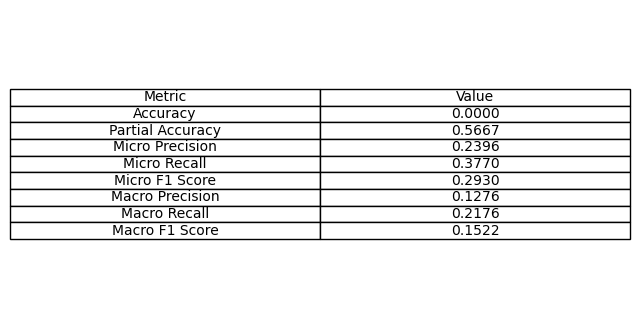

In [184]:
# evaluate the loaded model with a thresshold of 0.3
result = evaluate_model(reloaded_model, threshold=0.2, plot=False)

As we can see our algorithm does not perform well on the full dataset. We cant be satisfied with an accuracy of 0.053 for correctly classifying all the cars in an image.

Micro and Macro Precision are evaluated as well. They give us important insedes about the number of False Positives and False Negatives which are importent to know for determining the threshhold parameter of our algorithm.

## Refinement
As weve seen above the algorithm has multiple weaknesses. One issue to adress is the performance of our single-label classifier on the frames of an multi-car image. To do this we retrain the classifier with different parameters.

Since we use transfer learning we cant change the convolutional layers of the model. What we can do is add an additional Dropout Layer to reduce overfitting.

We also can change the learning rate of our Adams optimizer. Maybe we reach a local minimum of the error function in our training process. Changing the learning rate could help us identify this problem.

We train the following models:

**Baseline: F1_2019_Image_Classifier_V1**
- Feature_Extractor -> unchanged
- Dense Layer -> unchanged
Learning Rate = 0.0001

**F1_Image_Classifier_DO_0p1__LR_0p0001**
- Feature_Extractor -> unchanged
- Dropout Layer -> Dropout Rate = 0.1
- Dense Layer -> unchanged
Learning Rate = 0.0001

**F1_Image_Classifier_DO_0p15__LR_0p0001**
- Feature_Extractor -> unchanged
- Dropout Layer -> Dropout Rate = 0.15
- Dense Layer -> unchanged
Learning Rate = 0.0001

**F1_Image_Classifier_DO_0p15__LR_0p001**
- Feature_Extractor -> unchanged
- Dropout Layer -> Dropout Rate = 0.15
- Dense Layer -> unchanged
Learning Rate = 0.001

The models are all contained in the directory saved_models/

### Testing Multiple Models
After training multiple models for our single label classifier we need to check the performance of these models for single label classification as well as part of the multi-label classification.

We use an evaluation function which takes the inputs `model` and `threshhold`. We loop through all models and first evaluate the single-label classifier on the single-car test dateset. In a nested loop we also vary the threshhold for which a frame classification is consiererd valid and evaluate our alorithm on the multi-car test set.

saved_models/F1_Image_Classifier_DO_0p1__LR_0p0001.h5

Threshold:  0.2


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.8333333333333334
Micro Precision: 0.32142857142857145
Micro Recall: 0.5901639344262295
Micro F1 Score: 0.4161849710982659
Macro Precision: 0.2599310411810412
Macro Recall: 0.4167508417508417
Macro F1 Score: 0.2857758254817078

Threshold:  0.225


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.8333333333333334
Micro Precision: 0.34615384615384615
Micro Recall: 0.5901639344262295
Micro F1 Score: 0.43636363636363634
Macro Precision: 0.2740530303030303
Macro Recall: 0.4167508417508417
Macro F1 Score: 0.29830773801362037

Threshold:  0.25


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.06666666666666667
Partial Accuracy: 0.7666666666666667
Micro Precision: 0.36666666666666664
Micro Recall: 0.5409836065573771
Micro F1 Score: 0.4370860927152318
Macro Precision: 0.2786044973544974
Macro Recall: 0.3591750841750841
Macro F1 Score: 0.282010582010582

Threshold:  0.275


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.1
Partial Accuracy: 0.7666666666666667
Micro Precision: 0.43478260869565216
Micro Recall: 0.4918032786885246
Micro F1 Score: 0.46153846153846156
Macro Precision: 0.30624999999999997
Macro Recall: 0.3231902356902357
Macro F1 Score: 0.28797030175706645

Threshold:  0.3


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.06666666666666667
Partial Accuracy: 0.7333333333333333
Micro Precision: 0.45161290322580644
Micro Recall: 0.45901639344262296
Micro F1 Score: 0.45528455284552843
Macro Precision: 0.3138888888888889
Macro Recall: 0.28783670033670034
Macro F1 Score: 0.2815563725490196

Threshold:  0.325


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.06666666666666667
Partial Accuracy: 0.7333333333333333
Micro Precision: 0.4666666666666667
Micro Recall: 0.45901639344262296
Micro F1 Score: 0.4628099173553719
Macro Precision: 0.36515151515151517
Macro Recall: 0.31400367309458216
Macro F1 Score: 0.3101494094141153

Threshold:  0.35


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.7333333333333333
Micro Precision: 0.5294117647058824
Micro Recall: 0.4426229508196721
Micro F1 Score: 0.48214285714285715
Macro Precision: 0.36172248803827745
Macro Recall: 0.3057392102846648
Macro F1 Score: 0.30242527870611363

Threshold:  0.375


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.7333333333333333
Micro Precision: 0.5777777777777777
Micro Recall: 0.4262295081967213
Micro F1 Score: 0.49056603773584906
Macro Precision: 0.36616161616161613
Macro Recall: 0.2754361799816345
Macro F1 Score: 0.2860942978590037

Threshold:  0.4


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.06666666666666667
Partial Accuracy: 0.7
Micro Precision: 0.6097560975609756
Micro Recall: 0.4098360655737705
Micro F1 Score: 0.49019607843137253
Macro Precision: 0.35427807486631013
Macro Recall: 0.2527089072543618
Macro F1 Score: 0.2667481267886947
saved_models/F1_Image_Classifier_DO_0p15__LR_0p001.h5

Threshold:  0.2


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.8666666666666667
Micro Precision: 0.2900763358778626
Micro Recall: 0.6229508196721312
Micro F1 Score: 0.3958333333333333
Macro Precision: 0.23823215834085398
Macro Recall: 0.44574915824915823
Macro F1 Score: 0.29215880027900487

Threshold:  0.225


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.8666666666666667
Micro Precision: 0.296875
Micro Recall: 0.6229508196721312
Micro F1 Score: 0.4021164021164021
Macro Precision: 0.2433451009537966
Macro Recall: 0.44574915824915823
Macro F1 Score: 0.29652228809837505

Threshold:  0.25


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.8
Micro Precision: 0.3076923076923077
Micro Recall: 0.5901639344262295
Micro F1 Score: 0.4044943820224719
Macro Precision: 0.24766231152100715
Macro Recall: 0.38324915824915823
Macro F1 Score: 0.2849965823650034

Threshold:  0.275


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.8
Micro Precision: 0.32710280373831774
Micro Recall: 0.5737704918032787
Micro F1 Score: 0.4166666666666667
Macro Precision: 0.26462542087542085
Macro Recall: 0.37398989898989904
Macro F1 Score: 0.29121209887463756

Threshold:  0.3


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.8
Micro Precision: 0.35
Micro Recall: 0.5737704918032787
Micro F1 Score: 0.43478260869565216
Macro Precision: 0.2716600529100529
Macro Recall: 0.37398989898989904
Macro F1 Score: 0.29879846675512306

Threshold:  0.325


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.8
Micro Precision: 0.3888888888888889
Micro Recall: 0.5737704918032787
Micro F1 Score: 0.46357615894039733
Macro Precision: 0.282936507936508
Macro Recall: 0.37398989898989904
Macro F1 Score: 0.30630658363824

Threshold:  0.35


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.06666666666666667
Partial Accuracy: 0.8
Micro Precision: 0.4146341463414634
Micro Recall: 0.5573770491803278
Micro F1 Score: 0.4755244755244755
Macro Precision: 0.2979149262043999
Macro Recall: 0.3656565656565656
Macro F1 Score: 0.31052867383512545

Threshold:  0.375


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.06666666666666667
Partial Accuracy: 0.7666666666666667
Micro Precision: 0.4626865671641791
Micro Recall: 0.5081967213114754
Micro F1 Score: 0.484375
Macro Precision: 0.3286688944583681
Macro Recall: 0.3272306397306397
Macro F1 Score: 0.30696891659889763

Threshold:  0.4


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.06666666666666667
Partial Accuracy: 0.7666666666666667
Micro Precision: 0.5357142857142857
Micro Recall: 0.4918032786885246
Micro F1 Score: 0.5128205128205128
Macro Precision: 0.3836940836940837
Macro Recall: 0.34788797061524335
Macro F1 Score: 0.3370851370851371
saved_models/F1_Image_Classifier_DO_0p15__LR_0p0001.h5

Threshold:  0.2


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.9
Micro Precision: 0.37272727272727274
Micro Recall: 0.6721311475409836
Micro F1 Score: 0.47953216374269003
Macro Precision: 0.30976430976430974
Macro Recall: 0.5036195286195286
Macro F1 Score: 0.3526326500010711

Threshold:  0.225


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.9
Micro Precision: 0.4105263157894737
Micro Recall: 0.639344262295082
Micro F1 Score: 0.5
Macro Precision: 0.3195792633292633
Macro Recall: 0.4536195286195286
Macro F1 Score: 0.3497675813465287

Threshold:  0.25


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.06666666666666667
Partial Accuracy: 0.8333333333333334
Micro Precision: 0.4473684210526316
Micro Recall: 0.5573770491803278
Micro F1 Score: 0.49635036496350365
Macro Precision: 0.34679951690821254
Macro Recall: 0.3696548821548821
Macro F1 Score: 0.3386788048552754

Threshold:  0.275


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.06666666666666667
Partial Accuracy: 0.7666666666666667
Micro Precision: 0.5079365079365079
Micro Recall: 0.5245901639344263
Micro F1 Score: 0.5161290322580645
Macro Precision: 0.33888888888888885
Macro Recall: 0.32041245791245787
Macro F1 Score: 0.31052754435107377

Threshold:  0.3


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.06666666666666667
Partial Accuracy: 0.7
Micro Precision: 0.5283018867924528
Micro Recall: 0.45901639344262296
Micro F1 Score: 0.49122807017543857
Macro Precision: 0.35753968253968255
Macro Recall: 0.2861531986531986
Macro F1 Score: 0.29275793650793647

Threshold:  0.325


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.1
Partial Accuracy: 0.6333333333333333
Micro Precision: 0.6097560975609756
Micro Recall: 0.4098360655737705
Micro F1 Score: 0.49019607843137253
Macro Precision: 0.3888888888888889
Macro Recall: 0.28388429752066113
Macro F1 Score: 0.2974025974025974

Threshold:  0.35


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.6333333333333333
Micro Precision: 0.6470588235294118
Micro Recall: 0.36065573770491804
Micro F1 Score: 0.4631578947368421
Macro Precision: 0.5111111111111111
Macro Recall: 0.26909090909090905
Macro F1 Score: 0.2853246753246753

Threshold:  0.375


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.5
Micro Precision: 0.6296296296296297
Micro Recall: 0.2786885245901639
Micro F1 Score: 0.38636363636363635
Macro Precision: 0.2980392156862745
Macro Recall: 0.19444444444444442
Macro F1 Score: 0.2107338638373121

Threshold:  0.4


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.03333333333333333
Partial Accuracy: 0.5
Micro Precision: 0.6538461538461539
Micro Recall: 0.2786885245901639
Micro F1 Score: 0.39080459770114945
Macro Precision: 0.2980392156862745
Macro Recall: 0.19444444444444442
Macro F1 Score: 0.2107338638373121
saved_models/F1_2019_Image_Classifier_V1.h5

Threshold:  0.2


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.0
Partial Accuracy: 0.5666666666666667
Micro Precision: 0.23958333333333334
Micro Recall: 0.3770491803278688
Micro F1 Score: 0.2929936305732484
Macro Precision: 0.12756167443667443
Macro Recall: 0.21755050505050502
Macro F1 Score: 0.15218253968253967

Threshold:  0.225


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.0
Partial Accuracy: 0.5
Micro Precision: 0.2571428571428571
Micro Recall: 0.29508196721311475
Micro F1 Score: 0.2748091603053435
Macro Precision: 0.12413609782030836
Macro Recall: 0.17756734006734007
Macro F1 Score: 0.13405067155067155

Threshold:  0.25


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.0
Partial Accuracy: 0.3333333333333333
Micro Precision: 0.2682926829268293
Micro Recall: 0.18032786885245902
Micro F1 Score: 0.21568627450980393
Macro Precision: 0.13952020202020202
Macro Recall: 0.11505968778696052
Macro F1 Score: 0.110889597731703

Threshold:  0.275


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.0
Partial Accuracy: 0.16666666666666666
Micro Precision: 0.23809523809523808
Micro Recall: 0.08196721311475409
Micro F1 Score: 0.12195121951219512
Macro Precision: 0.11428571428571428
Macro Recall: 0.045757575757575754
Macro F1 Score: 0.06468253968253967

Threshold:  0.3


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.0
Partial Accuracy: 0.06666666666666667
Micro Precision: 0.125
Micro Recall: 0.03278688524590164
Micro F1 Score: 0.05194805194805195
Macro Precision: 0.06666666666666667
Macro Recall: 0.018333333333333333
Macro F1 Score: 0.028717948717948714

Threshold:  0.325


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.0
Partial Accuracy: 0.0
Micro Precision: 0.0
Micro Recall: 0.0
Micro F1 Score: 0.0
Macro Precision: 0.0
Macro Recall: 0.0
Macro F1 Score: 0.0

Threshold:  0.35


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.0
Partial Accuracy: 0.0
Micro Precision: 0.0
Micro Recall: 0.0
Micro F1 Score: 0.0
Macro Precision: 0.0
Macro Recall: 0.0
Macro F1 Score: 0.0

Threshold:  0.375


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.0
Partial Accuracy: 0.0
Micro Precision: 0.0
Micro Recall: 0.0
Micro F1 Score: 0.0
Macro Precision: 0.0
Macro Recall: 0.0
Macro F1 Score: 0.0

Threshold:  0.4


c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\P335437\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.0
Partial Accuracy: 0.0
Micro Precision: 0.0
Micro Recall: 0.0
Micro F1 Score: 0.0
Macro Precision: 0.0
Macro Recall: 0.0
Macro F1 Score: 0.0
    Threshold  Accuracy  Partial Accuracy  Micro Precision  Micro Recall  \
0       0.200  0.033333          0.833333         0.321429      0.590164   
1       0.225  0.033333          0.833333         0.346154      0.590164   
2       0.250  0.066667          0.766667         0.366667      0.540984   
3       0.275  0.100000          0.766667         0.434783      0.491803   
4       0.300  0.066667          0.733333         0.451613      0.459016   
5       0.325  0.066667          0.733333         0.466667      0.459016   
6       0.350  0.033333          0.733333         0.529412      0.442623   
7       0.375  0.033333          0.733333         0.577778      0.426230   
8       0.400  0.066667          0.700000         0.609756      0.409836   
9       0.200  0.033333          0.866667         0.290076      0.622951   
10      0.

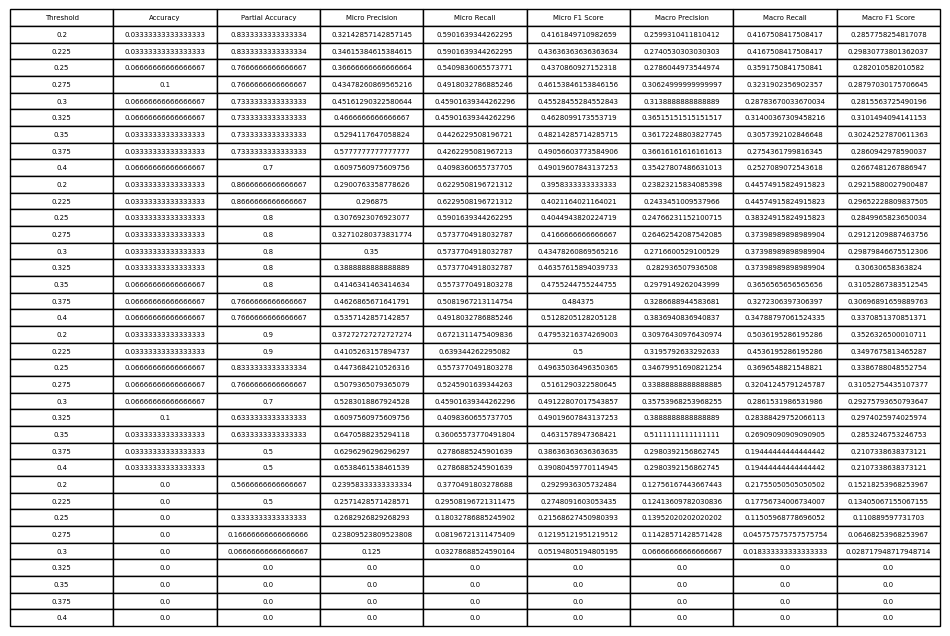

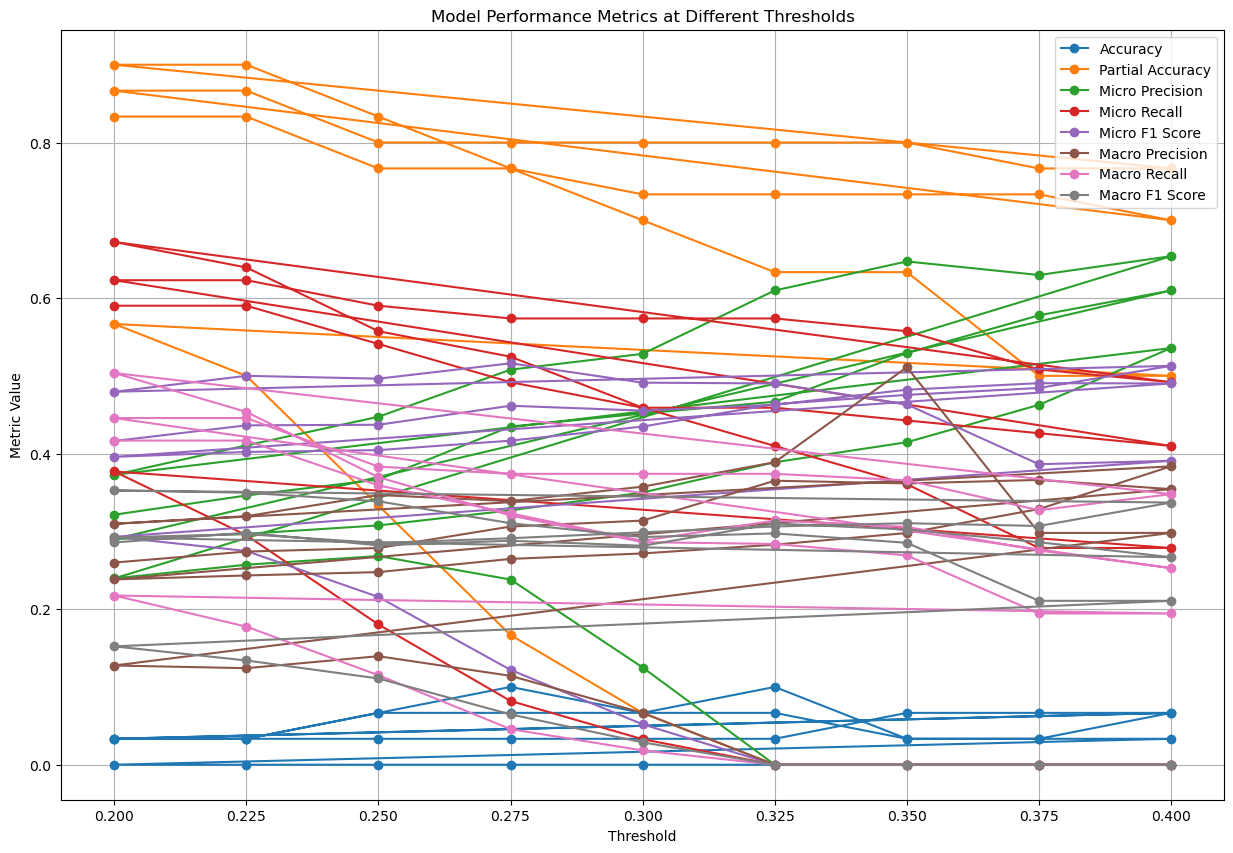

In [190]:
# define models to evaluate
model_name_lst = ['saved_models/F1_Image_Classifier_DO_0p1__LR_0p0001.h5',\
                  'saved_models/F1_Image_Classifier_DO_0p15__LR_0p001.h5',\
                  'saved_models/F1_Image_Classifier_DO_0p15__LR_0p0001.h5',\
                  'saved_models/F1_2019_Image_Classifier_V1.h5',\
                 ]

threshhold_lst = [0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4]
# threshhold_lst = [0.2, 0.225]
result_lst = []

# loop over all available models paths and load them
for model_name in model_name_lst:
    print(model_name)

    # Load and evaluate each model at different thresholds
    for threshold in threshhold_lst:
        # print('\nThreshold: ', threshold)
        model = tf_keras.models.load_model(model_name, custom_objects={'KerasLayer': hub.KerasLayer})
        result = evaluate_model(model, threshold, plot=False)
        result['Threshold'] = threshold  # Add threshold to the result
        result_lst.append(result)

# Create a DataFrame from the results list
results_df = pd.DataFrame(result_lst)
columns = ['Threshold'] + [col for col in results_df.columns if col != 'Threshold']
results_df = results_df[columns]

# Display the DataFrame
print(results_df)

# Optionally plot the table using matplotlib
fig, ax = plt.subplots(figsize=(12, 6))  # set size frame
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
plt.show()

# # Plot each metric
# plt.figure(figsize=(15, 10))
# metrics = [col for col in results_df.columns if col != 'Threshold']
# for metric in metrics:
#     plt.plot(results_df['Threshold'], results_df[metric], marker='o', label=metric)

# plt.xlabel('Threshold')
# plt.ylabel('Metric Value')
# plt.title('Model Performance Metrics at Different Thresholds')
# plt.legend()
# plt.grid(True)
# plt.show()


# Results

## Model Evaluation and Validation

The result of the model evaluation shows the best performance for:

**Single-Label Classifier: saved_models/`F1_Image_Classifier_DO_0p1__LR_0p0001`.h5**
- Loss on the single car Test Set: 1.179
- Accuracy on the single car Test Set: 81.537%
- Threshhold = 0.275
    - Accuracy: 0.10
    - Precision: 0.76
    - Recall: 0.43
    - F1 Score: 0.49

<img src="images/CrossValidation.jpg" width=1200px>

## Justification
Based on the evaluation we have identyfied the best performing model and parameters. There are however some problems with certain elements of our approach which lead to a low performance at the task hand:
- **Object Detection performance**

    For the scope of this project weve decided on using a pre trained [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html). This choice limited our options for the detection of Formula 1 cars. We tested different models and used [checkcas.xml](https://github.com/abhi-kumar/CAR-DETECTION/blob/master/checkcas.xml). This algorithm is perfectly capable of detecting cars in a traffic situation:
    
    <img src="images/Haar_Cascade_Traffic_Detection.JPG" width=400px>

    But not very effective of identifying Formula 1 cars in racing situations: 

    <img src="images/Haar_Cascade_Formula1_Detection.JPG" width=400px>

    

- **Sinlge-Label Classification performance**

    Another problem is the performance of our single-label classifier. It performs reasonably well on our test data of single car images with an accuracy of 81.5%.    
    When dealing with frames provided by the object detection however, the performance is significally lower. It could be that the algorithm is only performing well with images of whole cars and not just frames. Another possible explaination could be that the classifier performs badly when more then one car is in the frame:

    <img src="images/Single_Label_Classifier.png" width=400px>
    
    Classification Result: Alfa Romeo

# Conclusion
## Reflection
Admittedly, the performance of the end-to-end algorithm is lower than expected. The best accuracy we could achieve with this approach is 0.105, with accuracy being defined as correctly classifying **all** 1 cars in the image. The problems discussed above could be interesting to tackle but would go beyond the scope of this project.

It was interesting to experiment with object detection and single-label classification and try to combine the two approaches in a way that mitigates some of their weaknesses.

The most interesting aspect for me was trying to find a single-label classifier that works well for subframes of images.

## Improvement
Based on the evaluation, we have identified the best performing model and parameters. However, there are some issues with certain elements of our approach that lead to low performance at the task at hand:
- **Object Detection performance**

    For the scope of this project weve decided on using a pre trained [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html). This choice limited our options for the detection of Formula 1 cars. We tested different models and used [checkcas.xml](https://github.com/abhi-kumar/CAR-DETECTION/blob/master/checkcas.xml). This algorithm is perfectly capable of detecting cars in a traffic situation:
    
    <img src="images/Haar_Cascade_Traffic_Detection.JPG" width=400px>

    But not very effective of identifying Formula 1 cars in racing situations: 

    <img src="images/Haar_Cascade_Formula1_Detection.JPG" width=400px>

    Here lies one of the biggest improvements. Better object detection would provide fewer and better frames for the single-label classifier to work with.

    One interesting aspect to consider here is the number of frames provided by the object detection. In our implementation, it is very high with up to 30 frames per image. Each frame provides an opportunity for misclassification. By reducing the number of frames, we might be able to increase the threshold and use only classifications with high confidence, thereby improving our accuracy.  

- **Sinlge-Label Classification performance**

    Another problem is the performance of our single-label classifier. It performs reasonably well on our test data of single car images with an accuracy of 81.5%.
    However, when dealing with frames provided by the object detection, the performance is significantly lower. It could be that the algorithm is only performing well with images of whole cars and not just frames. Another possible explanation could be that the classifier performs poorly when more than one car is in the frame:

    <img src="images/Single_Label_Classifier.png" width=400px>
    
    Classification Result: Alfa Romeo

    Different training data selection could potentially improve this aspect. We used rendered images for training due to the limited availability of labeled images of single F1 cars on the track. A better training set could significantly improve performance.

# References
This blog post is part of my Udacity Data Scientist Nanodegree program. A blog post describing the project can be found here:

[Blogpost](https://medium.com/@albert.flatscher88/multi-label-image-classification-for-formula-1-cars-7751a999fcf9)
